In [1]:
!pip3 install box2d-py

     |████████████████████████████████| 450kB 10.0MB/s 


In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import random
import math
from torch.utils.tensorboard import SummaryWriter
from collections import deque, namedtuple
import time
import gym


def weight_init(layers):
    for layer in layers:
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

In [ ]:
print(gym.envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [44]:
class DDQN(nn.Module):
    def __init__(self, state_size, action_size,layer_size, seed, layer_type="ff"):
        super(DDQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_shape = state_size
        self.action_size = action_size

        self.head_1 = nn.Linear(self.input_shape[0], layer_size)
        self.ff_1 = nn.Linear(layer_size, layer_size)
        self.ff_2 = nn.Linear(layer_size, action_size)
        # self.ff_1 = nn.Linear(layer_size, layer_size)
        # self.ff_2 = nn.Linear(layer_size, layer_size//2)
        # self.ff_3 = nn.Linear(layer_size//2, action_size)
        weight_init([self.head_1, self.ff_1])
    
    def forward(self, input):
        """
        
        """
        x = torch.relu(self.head_1(input))
        x = torch.relu(self.ff_1(x))
        # x = torch.relu(self.ff_2(x))
        out = self.ff_2(x)
        # out = self.ff_3(x)
        
        return out

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device, seed, gamma, n_step=1):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.gamma = gamma
        self.n_step = n_step
        self.n_step_buffer = deque(maxlen=self.n_step)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        #print("before:", state,action,reward,next_state, done)
        self.n_step_buffer.append((state, action, reward, next_state, done))
        if len(self.n_step_buffer) == self.n_step:
            state, action, reward, next_state, done = self.calc_multistep_return()
            #print("after:",state,action,reward,next_state, done)
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)
    
    def calc_multistep_return(self):
        Return = 0
        for idx in range(self.n_step):
            Return += self.gamma**idx * self.n_step_buffer[idx][2]
        
        return self.n_step_buffer[0][0], self.n_step_buffer[0][1], Return, self.n_step_buffer[-1][3], self.n_step_buffer[-1][4]
        
    
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
class M_DQN_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self,
                 state_size,
                 action_size,
                 layer_size,
                 BATCH_SIZE,
                 BUFFER_SIZE,
                 LR,
                 TAU,
                 GAMMA,
                 UPDATE_EVERY,
                 device,
                 seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            layer_size (int): size of the hidden layer
            BATCH_SIZE (int): size of the training batch
            BUFFER_SIZE (int): size of the replay memory
            LR (float): learning rate
            TAU (float): tau for soft updating the network weights
            GAMMA (float): discount factor
            UPDATE_EVERY (int): update frequency
            device (str): device that is used for the compute
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.TAU = TAU
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.BATCH_SIZE = BATCH_SIZE
        self.Q_updates = 0

        self.action_step = 4
        self.last_action = None
    
        # Q-Network
        self.qnetwork_local = DDQN(state_size, action_size,layer_size, seed).to(device)
        self.qnetwork_target = DDQN(state_size, action_size,layer_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        print(self.qnetwork_local)
        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, self.device, seed, self.GAMMA, 1)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, writer):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.BATCH_SIZE:
                experiences = self.memory.sample()
                loss = self.learn(experiences)
                self.Q_updates += 1
                writer.add_scalar("Q_loss", loss, self.Q_updates)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy. Acting only every 4 frames!
        
        Params
        ======
            frame: to adjust epsilon
            state (array_like): current state
            
        """

        if self.action_step == 4:
            state = np.array(state)

            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
            self.qnetwork_local.train()

            # Epsilon-greedy action selection
            if random.random() > eps: # select greedy action if random number is higher than epsilon or noisy network is used!
                action = np.argmax(action_values.cpu().data.numpy())
                self.last_action = action
                return action
            else:
                action = random.choice(np.arange(self.action_size))
                self.last_action = action 
                return action
            #self.action_step = 0
        else:
            self.action_step += 1
            return self.last_action

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        self.optimizer.zero_grad()
        states, actions, rewards, next_states, dones = experiences
        # Get predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach()
        # calculate entropy term with logsum 
        logsum = torch.logsumexp(\
                                (Q_targets_next - Q_targets_next.max(1)[0].unsqueeze(-1))/entropy_tau , 1).unsqueeze(-1)

        tau_log_pi_next = Q_targets_next - Q_targets_next.max(1)[0].unsqueeze(-1) - entropy_tau*logsum
        # target policy
        pi_target = F.softmax(Q_targets_next/entropy_tau, dim=1)
        Q_target = (self.GAMMA * (pi_target * (Q_targets_next-tau_log_pi_next)*(1 - dones)).sum(1)).unsqueeze(-1)
        
        # calculate munchausen addon with logsum trick
        q_k_targets = self.qnetwork_target(states).detach()
        v_k_target = q_k_targets.max(1)[0].unsqueeze(-1)
        logsum = torch.logsumexp((q_k_targets - v_k_target)/entropy_tau, 1).unsqueeze(-1)
        log_pi = q_k_targets - v_k_target - entropy_tau*logsum
        munchausen_addon = log_pi.gather(1, actions)
        
        # calc munchausen reward:
        munchausen_reward = (rewards + alpha*torch.clamp(munchausen_addon, min=lo, max=0))
        
        # Compute Q targets for current states 
        Q_targets = munchausen_reward + Q_target
        
        # Get expected Q values from local model
        q_k = self.qnetwork_local(states)
        Q_expected = q_k.gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets) #mse_loss
        # Minimize the loss
        loss.backward()
        #clip_grad_norm_(self.qnetwork_local.parameters(),1)
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target)
        return loss.detach().cpu().numpy()            

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.TAU*local_param.data + (1.0-self.TAU)*target_param.data)

def eval_runs(eps, frame, game_type):
    """
    Makes an evaluation run with the current epsilon
    """
    env = gym.make(game_type)
    reward_batch = []
    for i in range(5):
        state = env.reset()
        rewards = 0
        while True:
            action = agent.act(state, eps)
            state, reward, done, _ = env.step(action)
            rewards += reward
            if done:
                break
        reward_batch.append(rewards)
        
    writer.add_scalar("Reward", np.mean(reward_batch), frame)


In [6]:
def run(frames=1000, eps_fixed=False, eps_frames=1e6, min_eps=0.01, game_type="CartPole-v0"):
    """Deep Munchausen Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    output_history = []
    score_per_ep = []
    frame = 0
    if eps_fixed:
        eps = 0
    else:
        eps = 1
    eps_start = 1
    i_episode = 1
    state = env.reset()
    score = 0                  
    for frame in range(1, frames+1):

        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done, writer)
        state = next_state
        score += reward
        # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
        if eps_fixed == False:
            if frame < eps_frames:
                eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
            else:
                eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
        
        # evaluation runs
        if frame % 1000 == 0:
            eval_runs(eps, frame, game_type)
        
        if done:
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            writer.add_scalar("Average100", np.mean(scores_window), frame)
            output_history.append(np.mean(scores_window))
            score_per_ep.append(np.mean(scores_window))
            print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
            i_episode +=1 
            state = env.reset()
            score = 0              

    return output_history, score_per_ep

In [17]:
writer = SummaryWriter("runs/"+"M-DQN_CP")
seed = 4
BUFFER_SIZE = 100000
BATCH_SIZE = 8
GAMMA = 0.99
TAU = 1e-2
LR = 1e-3
UPDATE_EVERY = 1
lo = -1
entropy_tau = 0.03
alpha = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
game_type = 'CartPole-v0'
print("Using ", device)




np.random.seed(seed)
env = gym.make(game_type)

env.seed(seed)
action_size     = env.action_space.n
state_size = env.observation_space.shape

agent = M_DQN_Agent(state_size=state_size,    
                    action_size=action_size,
                    layer_size=256,
                    BATCH_SIZE=BATCH_SIZE, 
                    BUFFER_SIZE=BUFFER_SIZE, 
                    LR=LR, 
                    TAU=TAU, 
                    GAMMA=GAMMA, 
                    UPDATE_EVERY=UPDATE_EVERY, 
                    device=device, 
                    seed=seed)



# set epsilon frames to 0 so no epsilon exploration
eps_fixed = False

t0 = time.time()
final_average100, score_per_ep = run(frames = 10000, eps_fixed=eps_fixed, eps_frames=5000, min_eps=0.025, game_type=game_type)
t1 = time.time()

print(len(score_per_ep))

print("\nTraining time: {}min".format(round((t1-t0)/60,2)))
torch.save(agent.qnetwork_local.state_dict(), "M-DQN-CP"+".pth")

Using  cpu
DDQN(
  (head_1): Linear(in_features=4, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=2, bias=True)
)
Episode 100	Frame 7867	Average Score: 78.67
Episode 110	Frame 9835 	Average Score: 96.10110

Training time: 0.75min


In [45]:
writer = SummaryWriter("runs/"+"M-DQN_CP")
seed = 4
BUFFER_SIZE = 100000
BATCH_SIZE = 8
GAMMA = 0.99
TAU = 1e-2
LR = 1e-3
UPDATE_EVERY = 1
lo = -1
entropy_tau = 0.035
alpha = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
game_type = 'CartPole-v0'
print("Using ", device)




np.random.seed(seed)
env = gym.make(game_type)

env.seed(seed)
action_size     = env.action_space.n
state_size = env.observation_space.shape

agent = M_DQN_Agent(state_size=state_size,    
                    action_size=action_size,
                    layer_size=256,
                    BATCH_SIZE=BATCH_SIZE, 
                    BUFFER_SIZE=BUFFER_SIZE, 
                    LR=LR, 
                    TAU=TAU, 
                    GAMMA=GAMMA, 
                    UPDATE_EVERY=UPDATE_EVERY, 
                    device=device, 
                    seed=seed)



# set epsilon frames to 0 so no epsilon exploration
eps_fixed = False

t0 = time.time()
final_average100, score_per_ep = run(frames = 60000, eps_fixed=eps_fixed, eps_frames=5000, min_eps=0.025, game_type=game_type)
t1 = time.time()

print(len(score_per_ep))

print("\nTraining time: {}min".format(round((t1-t0)/60,2)))
torch.save(agent.qnetwork_local.state_dict(), "M-DQN-CP"+".pth")

Using  cpu
DDQN(
  (head_1): Linear(in_features=4, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=2, bias=True)
)
Episode 100	Frame 7872	Average Score: 78.72
Episode 200	Frame 25188	Average Score: 173.16
Episode 300	Frame 44678	Average Score: 194.90
Episode 379	Frame 59900 	Average Score: 194.22379

Training time: 4.73min


In [46]:
writer = SummaryWriter("runs/"+"M-DQN_LL")
seed = 4
BUFFER_SIZE = 100000
BATCH_SIZE = 8
GAMMA = 0.99
TAU = 1e-2
LR = 1e-3
UPDATE_EVERY = 1
lo = -1
entropy_tau = 0.03
alpha = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
game_type = 'LunarLander-v2'
print("Using ", device)




np.random.seed(seed)
env = gym.make(game_type)

env.seed(seed)
action_size     = env.action_space.n
state_size = env.observation_space.shape

agent = M_DQN_Agent(state_size=state_size,    
                    action_size=action_size,
                    layer_size=256,
                    BATCH_SIZE=BATCH_SIZE, 
                    BUFFER_SIZE=BUFFER_SIZE, 
                    LR=LR, 
                    TAU=TAU, 
                    GAMMA=GAMMA, 
                    UPDATE_EVERY=UPDATE_EVERY, 
                    device=device, 
                    seed=seed)



# set epsilon frames to 0 so no epsilon exploration
eps_fixed = False

t0 = time.time()
final_average100, score_per_ep2 = run(frames = 60000, eps_fixed=eps_fixed, eps_frames=5000, min_eps=0.025, game_type=game_type)
t1 = time.time()

print("\nTraining time: {}min".format(round((t1-t0)/60,2)))
torch.save(agent.qnetwork_local.state_dict(), "M-DQN-LL"+".pth")

Using  cpu
DDQN(
  (head_1): Linear(in_features=8, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=4, bias=True)
)
Episode 100	Frame 39845	Average Score: -108.26
Episode 135	Frame 59498 	Average Score: -4.72
Training time: 10.06min


In [47]:
with open("aster-orig.scores", 'w') as f:
  for score in score_per_ep2:
    f.write(str(score)+"\n")

In [9]:
import matplotlib.pyplot as plt

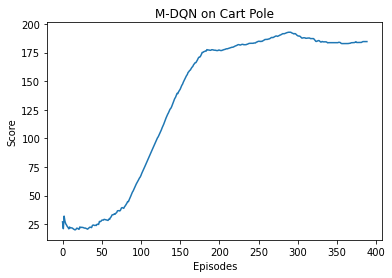

In [10]:
plt.plot(score_per_ep)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('M-DQN on Cart Pole')
plt.savefig('CartpoleDQN.png')

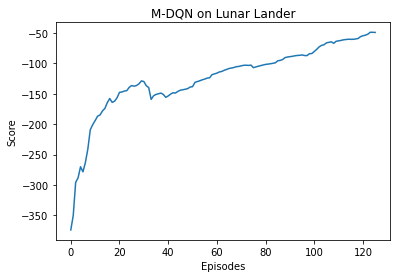

In [11]:
plt.plot(score_per_ep2)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('M-DQN on Lunar Lander')
plt.savefig('LunarLanderDQN.png')

In [40]:
writer = SummaryWriter("runs/"+"M-DQN_MP")
seed = 4
BUFFER_SIZE = 100000
BATCH_SIZE = 8
GAMMA = 0.99
TAU = 1e-2
LR = 1e-3
UPDATE_EVERY = 1
lo = -1
entropy_tau = 0.03
alpha = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
game_type = 'Alien-ram-v0'
print("Using ", device)




np.random.seed(seed)
env = gym.make(game_type)

env.seed(seed)
action_size     = env.action_space.n
state_size = env.observation_space.shape

agent = M_DQN_Agent(state_size=state_size,    
                    action_size=action_size,
                    layer_size=256,
                    BATCH_SIZE=BATCH_SIZE, 
                    BUFFER_SIZE=BUFFER_SIZE, 
                    LR=LR, 
                    TAU=TAU, 
                    GAMMA=GAMMA, 
                    UPDATE_EVERY=UPDATE_EVERY, 
                    device=device, 
                    seed=seed)



# set epsilon frames to 0 so no epsilon exploration
eps_fixed = False

t0 = time.time()
final_average100, score_per_ep4 = run(frames = 60000, eps_fixed=eps_fixed, eps_frames=5000, min_eps=0.025, game_type=game_type)
t1 = time.time()

print("\nTraining time: {}min".format(round((t1-t0)/60,2)))
torch.save(agent.qnetwork_local.state_dict(), "M-DQN-MP"+".pth")

Using  cpu
DDQN(
  (head_1): Linear(in_features=128, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=128, bias=True)
  (ff_3): Linear(in_features=128, out_features=18, bias=True)
)
Episode 77	Frame 59484 	Average Score: 400.26
Training time: 12.66min


In [41]:
writer = SummaryWriter("runs/"+"M-DQN_AS")
seed = 4
BUFFER_SIZE = 100000
BATCH_SIZE = 8
GAMMA = 0.99
TAU = 1e-2
LR = 1e-3
UPDATE_EVERY = 1
lo = -1
entropy_tau = 0.03
alpha = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
game_type = 'Asteroids-ram-v0'
# Asteroids-v0, BeamRider-v0, Freeway-v0
print("Using ", device)




np.random.seed(seed)
env = gym.make(game_type)

env.seed(seed)
action_size     = env.action_space.n
state_size = env.observation_space.shape

agent = M_DQN_Agent(state_size=state_size,    
                    action_size=action_size,
                    layer_size=256,
                    BATCH_SIZE=BATCH_SIZE, 
                    BUFFER_SIZE=BUFFER_SIZE, 
                    LR=LR, 
                    TAU=TAU, 
                    GAMMA=GAMMA, 
                    UPDATE_EVERY=UPDATE_EVERY, 
                    device=device, 
                    seed=seed)



# set epsilon frames to 0 so no epsilon exploration
eps_fixed = False

t0 = time.time()
final_average100, score_per_ep5 = run(frames = 60000, eps_fixed=eps_fixed, eps_frames=5000, min_eps=0.025, game_type=game_type)
t1 = time.time()

print("\nTraining time: {}min".format(round((t1-t0)/60,2)))
torch.save(agent.qnetwork_local.state_dict(), "M-DQN-AS"+".pth")

Using  cpu
DDQN(
  (head_1): Linear(in_features=128, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=128, bias=True)
  (ff_3): Linear(in_features=128, out_features=14, bias=True)
)
Episode 78	Frame 59865 	Average Score: 361.54
Training time: 12.07min


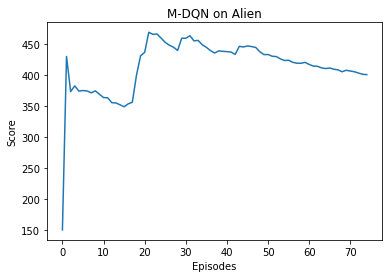

In [14]:
plt.plot(score_per_ep4)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('M-DQN on Alien')
plt.savefig('AlienDQN')

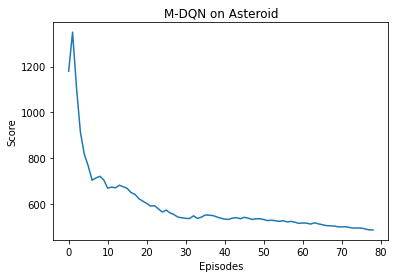

In [15]:
plt.plot(score_per_ep5)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('M-DQN on Asteroid')
plt.savefig('AsteroidDQN')